# Logistic regression

ก่อนหน้านี้  เราได้เรียนรู้ Simple Linear Model ทำให้เราสามารถพัฒนาโมเดลเชิงเส้น (linear model) เพื่อทำนายค่า $y$ โดยเรียนรู้จากชุดข้อมูลที่มีโดยไม่จำกัด range ของค่า $y$ ในกรณีที่ชุดข้อมูลประกอบด้วย 1 feature คือ $x$ เราสามารถเขียนสมการของความสัมพันธ์เชิงเส้นได้เป็น

$$y = w_0 + w_1x$$

โดยที่ $w_0$ และ $w_1$ คือ พารามิเตอร์ของโมเดลเชิงเส้น

อย่างไรก็ดี มีโจทย์ในอีกประเภทหนึ่ง คือ classification problem หรือ ปัญหาการจำแนกหมวดหมู่ ซึ่ง $y$ เป็น label ของหมวดหมู่ โดยมักแทนด้วยเป็นจำนวนเต็ม เพื่อให้สามารถทำงานกับระบบคำนวณของคอมพิวเตอร์ได้  ในกรณีที่ชุดข้อมูลประกอบด้วย 2 หมวดหมู่ หรือ binary-classification เรามักกำหนดให้ค่า $y$ มีค่าเป็น 0 หรือ 1 แทน label ของแต่ละหมวดหมู่  การพัฒนาโมเดลเชิงเส้นเพื่อจำแนกข้อมูลที่จำกัด range ของค่า $y$ โดยตรงจึงไม่เหมาะสม โดยเราสามารถใช้ฟังค์ชันทางคณิตศาสตร์เพื่อแปลงค่าให้อยู่ในช่วงที่เราต้องการได้ หนึ่งในฟังค์ชันที่มีคุณสมบัติดังกล่าว คือ logistic function หรือ Sigmoid function ซึ่งมีสมการทางคณิตศาสตร์ ดังนี้

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

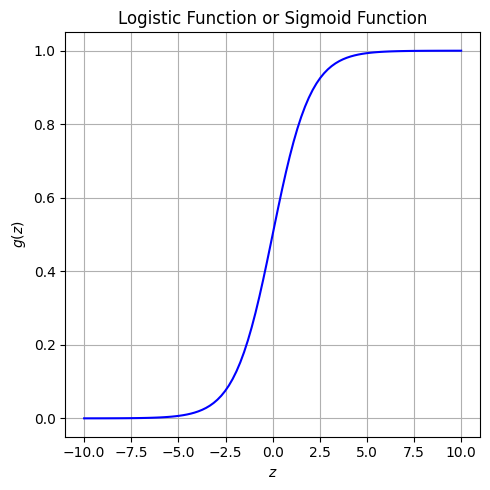

In [4]:
def sigmoid_function(y):
    return 1 / (1 + np.exp(-y))

# คำนวณค่า sigmoid function ด้วยช่วงค่า x ที่กำหนด
z   = np.linspace(-10, 10, 100)
sig = sigmoid_function(z)

# plot sigmoid function
plt.figure(figsize = (5,5))
plt.plot(z, sig, 'b')

plt.grid()
plt.xlabel('$z$')
plt.ylabel('$g(z)$')
plt.title('Logistic Function or Sigmoid Function')
plt.tight_layout()
plt.show()

จะเห็นได้ว่า logistic function มีค่าในช่วง 0 ถึง 1 เราจึงสามารถใช้ฟังค์ชันนี้แปลงผลรวมเชิงเส้นเป็นค่าความน่าจะเป็น (probability) ในการจำแนกคลาส
$$
P(x) = \frac{1}{1 + e^{-(w_0+w_1x)}}
$$
หรือ
$$
log\left(\frac{P(x)}{1-P(x)}\right) = w_0+w_1x
$$

และสามารถกำหนดเงื่อนไขการตัดสินใจหรือ decision boundary ที่ $P=0.5$ เพื่อใช้ในการจำแนกคลาสของ $y$ ซึ่งแสดงเป็นความสัมพันธ์ทางคณิตศาสตร์ได้ ดังนี้
- $P(x) ≥ 0.5 → y=1$
- $P(x) < 0.5 → y=0$

โมเดล logistic จะเรียนรู้จากชุดข้อมูล โดยปรับค่าพารามิเตอร์ของโมเดล $w_0$ และ $w_1$ เพื่อให้ค่า $y$ ที่ทำนายจากความน่าจะเป็นมีความคลาดเคลื่อนจากค่า $y$ ของข้อมูล มีความคลาดเคลื่อนน้อยที่สุด  และได้ decision boundary ที่สามารถจำแนกกลุ่มได้ดีที่สุด ด้วย iterative solver ประเภทต่างๆ

ในบทเรียนนี้เราจะเรียนรู้การทำ logistic regression ผ่านการเรียกใช้ `LogisticRegression` จากไลบรารี่ `scikit-learn` ที่จะแสดงต่อไป

## Generate simulated dataset
เพื่อเปรียบเทียบการทำงานของ Linear regression และ Logistic regression เราจะลองสร้างชุดข้อมูลที่ประกอบไปด้วย จำนวน $n=100$ จุด $(x_1,y_1), (x_2,y_2), ..., (x_i,y_i),.., (x_n,y_n)$

โดย $y$ มีค่า 0 หรือ 1 (2-class dataset for binary classification)

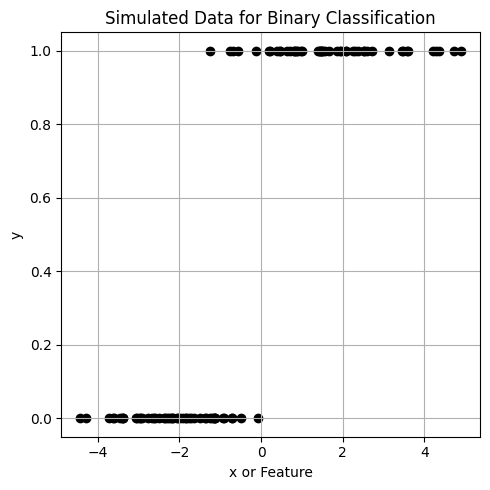

In [25]:
def generate_multi_class_dataset(n_classes, n_features, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนด จำนวน features
n_features = 1

# กำหนดค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [-2, 2]
std_class  = [1, 1.5]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส (รวม 100 จุด)
n_samples =  50

# ทำการสร้างชุดข้อมูล
x,y = generate_multi_class_dataset(n_classes, n_features, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีสร้างขึ้น
plt.figure(figsize = (5,5))
plt.scatter(x, y, c='k')
plt.grid()
plt.ylabel('y')
plt.xlabel('x or Feature')
plt.title('Simulated Data for Binary Classification')
plt.tight_layout()
plt.show()

เราจะลอง fit ข้อมูลชุดนี้ ด้วย [Linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) และ [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) จากไลบรารี่ `scikit-learn`

Linear model: R2 = 0.71
Linear regression: y(x) = x*0.18 + 0.54
Logistic model: accuracy = 0.95
Logistic regression: probability function P(x) = g(x*2.31 + 1.08)


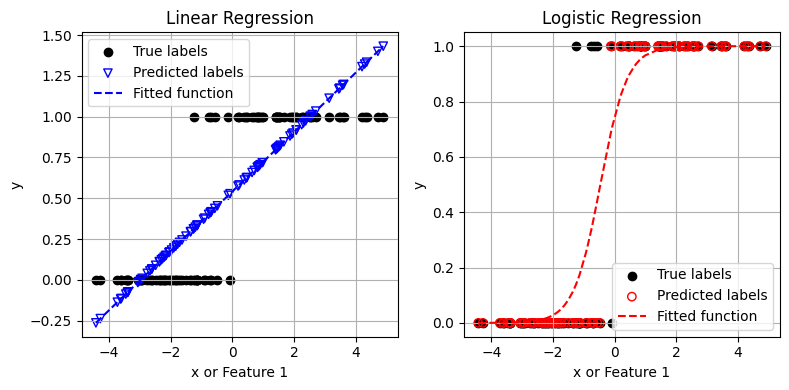

In [31]:
# สร้าง Linear Model
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
# สอนโมเดลจากข้อมูล x, y ที่มี แล้วทำนายค่า $y$
clf.fit(x, y)
y_linear = clf.predict(x)
print('Linear model: R2 = {:.2f}'.format(clf.score(x,y)))
sorted_x = np.sort(x.ravel())
y_linear_func = sorted_x*clf.coef_[0] + clf.intercept_
print('Linear regression: y(x) = x*{:.2f} + {:.2f}'.format(clf.coef_[0], clf.intercept_))

# สร้าง Logistic Model
clf = LogisticRegression()
# สอนโมเดลจากข้อมูล x, y ที่มี แล้วทำนายค่า $y$
clf.fit(x, y)
y_logit = clf.predict(x)
print('Logistic model: accuracy = {:.2f}'.format(clf.score(x,y)))
y_logit_func = sigmoid_function(sorted_x*clf.coef_[0] + clf.intercept_)
print('Logistic regression: probability function P(x) = g(x*{:.2f} + {:.2f})'.format(clf.coef_[0][0], clf.intercept_[0]))

# Plot ข้อมูล x, y ที่มีอยู่
fig, axes = plt.subplots(1,2, figsize=(8, 4))
ax = axes[0]
ax.scatter(x, y, c='k', marker='o', label='True labels')
ax.scatter(x, y_linear, edgecolor='b', marker='v', facecolors='none', label='Predicted labels')
ax.plot(np.sort(x.ravel()), y_linear_func, 'b--', label='Fitted function')
ax.set(xlabel='x or Feature 1', ylabel='y')
ax.set_title('Linear Regression')
ax.grid()
ax.legend()

ax = axes[1]
ax.scatter(x, y, c='k', marker='o', label='True labels')
ax.scatter(x, y_logit, edgecolor='r', marker='o', facecolors='none', label='Predicted labels')
ax.plot(np.sort(x.ravel()), y_logit_func, 'r--', label='Fitted function')
ax.set(xlabel='x or Feature 1', ylabel='y')
ax.set_title('Logistic Regression')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

จะเห็นได้ว่า ค่าที่ทำนายจากโมเดล linear regression มีความคลาดเคลื่อนสูงมาก ในขณะที่โมเดล logistic regression สามารถเรียนรู้และทำนายข้อมูลในลักษณะนี้ได้ดีกว่า โดยจะมีบางช่วงข้อมูลที่โมเดลทำนายคลาดเคลื่อน ซึ่งเป็นช่วงค่า $x$ ปรากฏข้อมูลทั้งสอง class และเนื่องจาก ชุดข้อมูลมีตัวแปร $x$ เพียงตัวเดียวจึงไม่เพียงพอในการจำแนกข้อมูลช่วงดังกล่าว

Quiz: Determine decision boundary, given $P(x) = g(x*2.13 + 1.08)$

*จะแสดงคำตอบในวิดีโอ*

ต่อไป เราจะลองสร้างชุดข้อมูลที่ feature space มีมิติสูงขึ้น โดยเป็นชุดข้อมูลที่ประกอบด้วย 2 features เพื่อจำแนก 2 classes

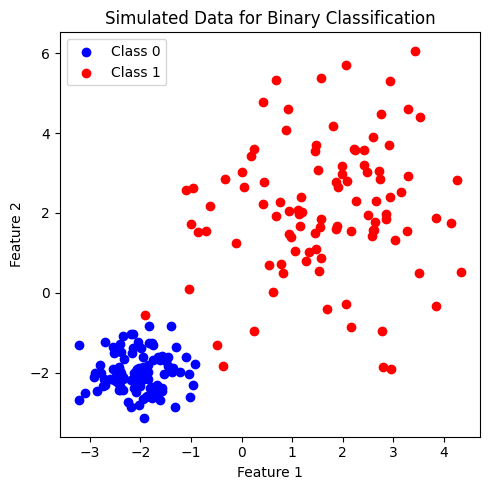

In [68]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนด จำนวน features
n_features = 2

# กำหนดช่วงค่า Mean และ standard deviation (SD) สำหรับแต่ละคลาส
# เนื่องจากเรากำหนดจำนวน features เป็น 2 จึงสามารถกำหนด Mean และ SD ด้วย array ของ 2 ค่า
mean_class = [[-2,-2], [2,2]]
std_class  = [[0.5,0.5], [1.5,1.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, n_features, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

## Decision Boundary

เราสามารถ visualize ลักษณะของ decision boundary โดยใช้ [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) จากไลบรารี่ `scikit-learn`

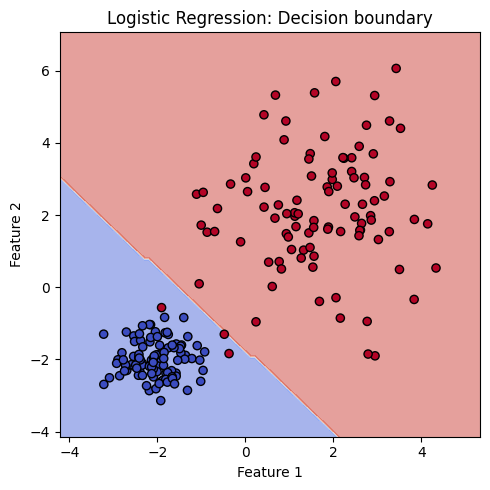

In [69]:
# สร้างโมเดล
clf = LogisticRegression()

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Logistic Regression: Decision boundary')
plt.tight_layout()
plt.show()

แสดง decision boundary ของโมเดล logistic regression ที่มีลักษณะเป็นเส้นตรง จำแนกกลุ่มข้อมูลออกจากกัน

## Logistic Regression เมื่อใช้ solvers ชนิดต่างๆ

ค่าพารามิเตอร์ $w$ ของโมเดล logistic ที่เหมาะสมที่สุดสามารถหาด้วย iterative solvers ที่ประมาณค่าคำตอบ โดยเดาค่าเริ่มต้นเพื่อคำนวณหาค่าคำตอบ และมีการปรับค่าซ้ำๆ เพื่อให้ได้ค่าคำตอบที่ถูกต้องมากขึ้น อาทิเช่น

**Newton-CG Solver**:
- ใช้วิธี Newton-Conjugate Gradient
- เหมาะสำหรับข้อมูลขนาดใหญ่ แต่จะใช้ computer time มากตามจำนวน features
- สามารถใช้ร่วมกับ L2 regularization

**lbfgs Solver (Limited-memory Broyden-Fletcher-Goldfarb-Shanno)**:
- ใช้ L-BFGS algorithm ในการค้นหาค่าพารามิเตอร์ที่เหมาะสม
- เหมาะสำหรับข้อมูลขนาดเล็กถึงกลาง
- เป็น default solver ของ `scikit-learn` ในการทำ Logistic Regression
- สามารถใช้ร่วมกับ L2 regularization

**liblinear Solver**:
- วิธีการนี้ใช้เทคนิคจากไลบรารี LIBLINEAR
- เหมาะสำหรับข้อมูลขนาดเล็ก
- สามารถใช้ร่วมกับ L1 และ L2 regularization

เราสามารถเลือกใช้ solver ที่เหมาะสมโดยยังมี hyperparameters อีก 2 ตัวที่กำหนดการหยุดทำงานของ iterative solvers เหล่านี้ ได้แก่
- 'tol' คือ ค่า tolerance เป็นการกำหนดระดับความแม่นยำ (precision) ของ คำตอบจาก iterative solver โดยเมื่อค่าคำตอบที่ได้จาก solver มีการเปลี่ยนแปลงน้อยกว่าค่า tolerance ที่กำหนด จะถือว่าได้ค่าตอบที่มีความถูกต้องในระดับความแม่นยำที่ต้องการ และหยุดการคำนวณ
- 'max_iter' กำหนดจำนวนครั้งมากที่สุดที่ให้ solver คำนวณหาค่าคำตอบ ก่อนยุติการคำนวณ

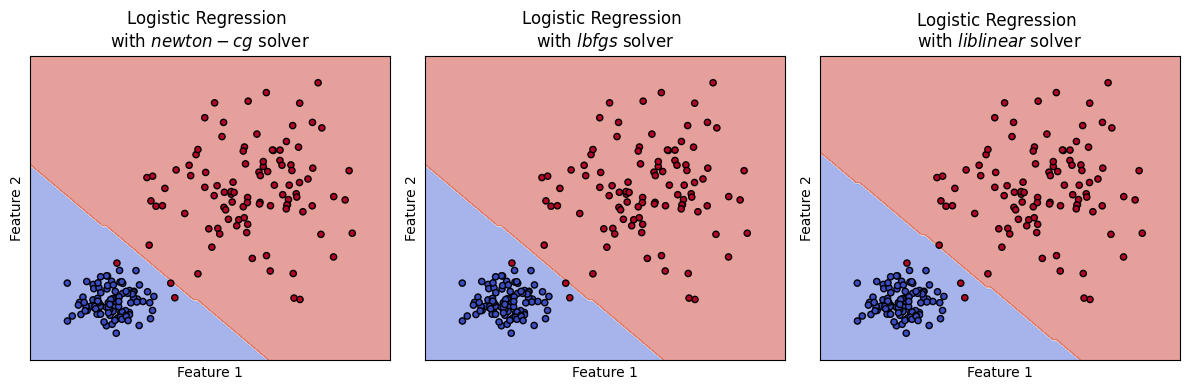

In [70]:
# สร้างชุดโมเดล
models = (LogisticRegression(solver='newton-cg', max_iter=100, tol=1e-4),
          LogisticRegression(solver='lbfgs', max_iter=100, tol=1e-4),
          LogisticRegression(solver='liblinear', max_iter=100, tol=1e-4),
          )
# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['Logistic Regression \nwith $newton-cg$ solver',
          'Logistic Regression \nwith $lbfgs$ solver',
          'Logistic Regression \nwith $liblinear$ solver',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

จะเห็นได้ว่า solvers ต่างๆ สามารถค้นหาค่าพารามิเตอร์ $w$ ที่เหมาะสม โดยมี Decision Boundary ที่ใกล้เคียงกัน ทั้งนี้ decision boundary ของโมเดล logistic regression จะประกอบขึ้นจากเส้นตรง

## Regularization

หากพบปัญหา overfitting หรือการเรียนรู้ข้อมูลสัญญาณที่เกินมากเกินไปจากข้อมูลฝึกสอน เราสามารถใช้ regularization ร่วมกับ logistic regression

ในไลบรารี่ `scikit-learn` เราสามารถปรับค่า Regularization Strength $\lambda$ ได้โดยผ่านทางพารามิเตอร์ $C$ โดย ค่า $C$ มีค่าเท่ากับ $1/\lambda$ (Inverse of Regularization Strength)


## Logistic regression pipeline

ต่อไปเราจะลองพัฒนาโมเดล logistic อย่างครบกระบวนการ

### Generate 3-class dataset

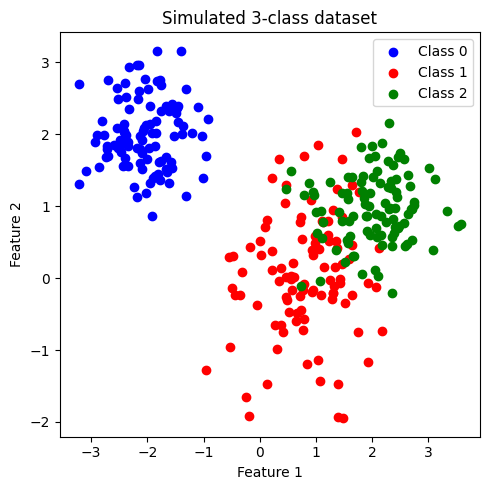

In [72]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนด จำนวน features
n_features = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]
std_class  = [[0.5,0.5], [0.75,0.75],[0.75,0.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, n_features, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()

ข้อมูลที่สร้างขึ้นมีประกอบด้วย 2 features และ label แบ่งเป็น 3 กลุ่ม (class: 0, 1, 2) เราจะพัฒนาโมเดล logistic regression เพื่อจำแนกข้อมูลในแต่ละกลุ่ม

เมื่อสังเกตการกระจายตัวของข้อมูล พบว่า class 0 มีการกระจายข้อมูลแบ่งแยกออกมาอย่างเห็นได้ชัด ในขณะที่ class 1 และ class 2 จะกระจายตัวอยู่ร่วมกัน

### แบ่งข้อมูลเป็น training data และ test data

โดยใช้ [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) จากไลบรารี่ `scikit-learn`

ในตัวอย่างนี้เราจะใช้ default value ซึ่งจะ shuffle ข้อมูลก่อนแบ่งข้อมูล และ ไม่ stratify (ไม่กำกับสัดส่วนของ class ใน training data และ test data)

อย่างไรก็ดี ในกรณีที่ข้อมูลประกอบด้วย class ต่างๆ ที่มีสัดส่วนต่างกันอย่างมาก (imbalanced dataset) การทำ stratify มีความจำเป็นอย่างมากเพื่อคงสัดส่วนของแต่ละ class ใน training data และ test data

In [73]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=None, random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 82.]
 [ 1. 79.]
 [ 2. 79.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 18.]
 [ 1. 21.]
 [ 2. 21.]]


### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ standard deviation (SD) จาก training data ในการ standardize test set เพื่อป้องกัน information leak

In [74]:
# สร้าง standardized scaler จาก features ใน training data
x_scaler = StandardScaler().fit(x_train)

# scale ค่า features ใน training data และ test data
x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        82
         1.0       0.91      0.89      0.90        79
         2.0       0.89      0.91      0.90        79

    accuracy                           0.93       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.93      0.67      0.78        21
         2.0       0.74      0.95      0.83        21

    accuracy                           0.87        60
   macro avg       0.89      0.87      0.87        60
weighted avg       0.89      0.87      0.86        60



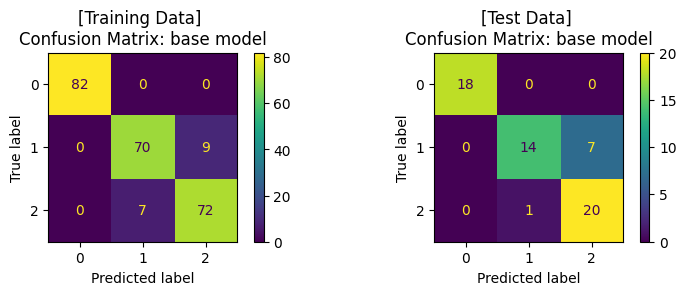

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# สร้างโมเดล
base_clf = LogisticRegression()

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Data] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### ปรับแต่งโมเดล (Hyperparameter Tuning) ด้วย [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) และ train โมเดล

โดยเราจะปรับแต่งโมเดล โดย tune 2 hyperparameters ที่สำคัญของ logistic regression ได้แก่
1. 'solver'
2. 'C'

ในไลบรารี่ `scikit-learn` ยังมีวิธีการอื่นๆ ในการปรับแต่งโมเดล เช่น
- [CrossValScore](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.92
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        82
         1.0       0.88      0.90      0.89        79
         2.0       0.90      0.87      0.88        79

    accuracy                           0.93       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.93      0.93      0.92       240


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.94      0.71      0.81        21
         2.0       0.77      0.95      0.85        21

    accuracy                           0.88        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.88      0.88        60



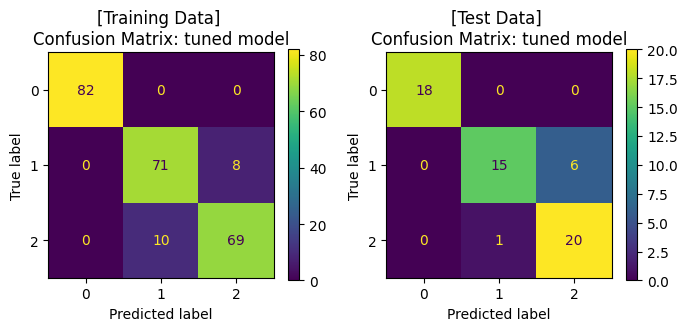

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'solver': ['newton-cg','lbfgs','liblinear'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l2']
              }

# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Data] \nConfusion Matrix: tuned model')

plt.show()

จะสังเกตได้ว่า เมื่อมีการปรับจูน hyperparameters ของโมเดลให้มีความเหมาะสมแล้ว เราได้โมเดลที่เรียนรู้จากข้อมูลชุดเดิม แล้วสามารถทำนายได้ค่า accuracy ที่สูงขึ้น โดยเมื่อพิจารณา Confusion Matrix จะพบว่า โมเดลสามารถจำแนกข้อมูล class 1 และ class 2 ได้ดีขึ้น

### Decision Boundary

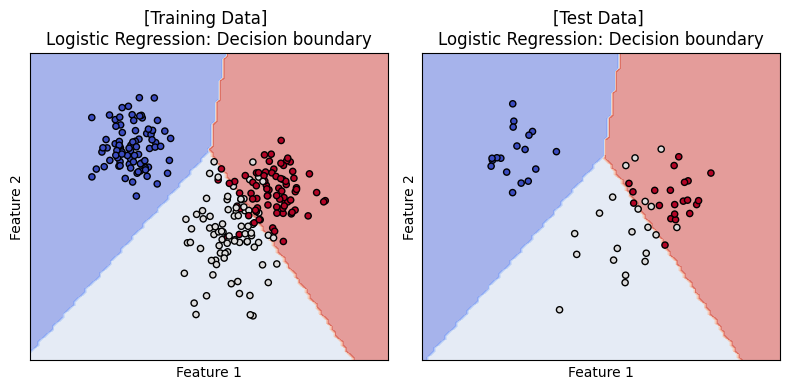

In [87]:
# plot the decision boundaries
fig, axes = plt.subplots(1,2, figsize=(8, 4))
titles = ['[Training Data] \nLogistic Regression: Decision boundary', '[Test Data] \nLogistic Regression: Decision boundary']
for x, y, title, ax in zip([x_train, x_test], [y_train, y_test], titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(tuned_clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

เมื่อชุดข้อมูลประกอบด้วย 3 คลาส decision boundary ของโมเดล logistic regression ยังคงประกอบเส้นตรง เพื่อจำแนกกลุ่มข้อมูลออกจากกัน